In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [89]:
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, ToolMessage, AnyMessage
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.graph import StateGraph, END
from IPython.display import Image, display
from langchain_anthropic import ChatAnthropic
from typing import TypedDict, Annotated
from uuid import uuid4
from langchain_groq import ChatGroq
import operator


In [3]:
ts_tool =TavilySearchResults(max_results=2)

C:\Users\badho\AppData\Local\Temp\ipykernel_8988\2616099802.py:1: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  ts_tool =TavilySearchResults(max_results=2)


In [4]:
ts_tool.invoke("What is the capital of France?")

[{'title': 'Paris, the capital of France, is often referred to as the "City of Light ...',
  'url': 'https://www.instagram.com/reel/DEVmGsIMGRM/?hl=en',
  'content': 'Paris, the capital of France, is often referred to as the "City of Light" and is renowned for its art, culture, and history. It is home to iconic landmarks like the Eiffel Tower, Notre-Dame Cathedral, and the Louvre Museum, which houses the famous Mona Lisa. Known for its romantic ambiance, Paris boasts charming streets, world-class cuisine, chic boutiques, and vibrant cafes. The city is also a global hub for fashion and luxury, offering a unique blend of historical charm and modern',
  'score': 0.9989434},
 {'title': 'Paris facts: the capital of France in history',
  'url': 'https://home.adelphi.edu/~ca19535/page%204.html',
  'content': '|  |  |  |  |  |  |  |\n ---  ---  --- \n| Home | Spain | Sydney | San Francisco | Paris | Las Vegas | Maui |\n\n  \n Paris, France\n\n  \n\n## Paris facts: Paris, the capital of France\

In [ ]:
# llm = ChatAnthropic(
#     model="claude-haiku-4-5-20251001",
#     temperature=0,
#     max_tokens=1024,
#     timeout=None,
#     max_retries=2,
# )

In [62]:
llm = ChatGroq(model = "llama-3.1-8b-instant")

In [63]:
llm.invoke("Do you know who is the current prime minister of Bangladesh").content

'As of my knowledge cutoff date (01 March 2023), the current Prime Minister of Bangladesh is Sheikh Hasina. She has been the Prime Minister since 2009 and is the leader of the Awami League party.'

### Building Agent

Custom reducer to have more flexibility
Goals:
1. Replacing any messages that are updated by human (eg. update tool calls params)
2. Appending new messages

In [208]:
def reduce_msg(left:list[AnyMessage], right:list[AnyMessage]) -> list[AnyMessage]:

    #Assigning uuid if not
    for msg in right:
        if not msg.id:
            msg.id = str(uuid4())
    
    merge = left.copy()
    for msg in right:

        for i,exiting_msg in enumerate(merge):
            # Goal 1: Replacing any messages that are updated by human (eg. update tool calls params)
            if msg.id == exiting_msg.id:
                merge[i] = msg
                break
        else:
            # Goal 2: Appending new messages
            merge.append(msg)
    return merge    

In [209]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], reduce_msg]
    

Agent: ......

In [267]:
class Agent():

    def __init__(self, llm, tools:list, checkpointer=None, is_interrupt=False, system_prompt:str="You are a helpful AI assistant."):
        self.llm = llm
        self.tools = tools
        self.system_prompt = system_prompt
        self.llm=self.llm.bind_tools(tools=tools)

        self.tools = {t.name: t for t in tools}

        graph = StateGraph(AgentState)
        graph.add_node("call_llm", self.call_llm)
        graph.set_entry_point("call_llm")

        graph.add_node("call_tool", self.call_tool)
        graph.add_edge("call_tool", "call_llm")
        graph.add_conditional_edges("call_llm", 
                                    self.has_tools_to_call,
                                    {
                                        True: "call_tool",
                                        False: END
                                    }
                                    )
        if is_interrupt:
            self.graph = graph.compile(checkpointer=checkpointer, interrupt_before=["call_tool"])
        else:
            self.graph = graph.compile(checkpointer=checkpointer)


    def call_llm(self, state:AgentState) -> AgentState:
        if self.system_prompt:
            messages = [SystemMessage(content=self.system_prompt)] + state["messages"]
        else:
            messages = state["messages"]
        response = self.llm.invoke(messages)
        return {"messages": [response]}
    
    def call_tool(self, state:AgentState) -> AgentState:

        last_message = state["messages"][-1]
        result = []

        if len(last_message.tool_calls)<1:
            raise Exception("No tool calls found in the last message")
        
        for tool_call in last_message.tool_calls:

            if tool_call['name'] not in self.tools:
                raise Exception(f"Tool {tool_call['name']} not found")
            print(f"Invoking tool: {tool_call['name']} with args: {tool_call['args']}")
            
            res = self.tools[tool_call['name']].invoke(tool_call['args'])

            result.append(ToolMessage(content=str(res), name=tool_call['name'], tool_call_id=tool_call['id']))

        return {"messages": result}
    
    def has_tools_to_call(self, state:AgentState) -> bool:
        last_message = state["messages"][-1]
        return len(last_message.tool_calls) > 0
            



In [235]:
from langgraph.checkpoint.sqlite import SqliteSaver

memory = SqliteSaver.from_conn_string(":memory:")

In [236]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [237]:
agent = Agent(llm, [ts_tool], memory, system_prompt="You are a helpful AI assistant.")

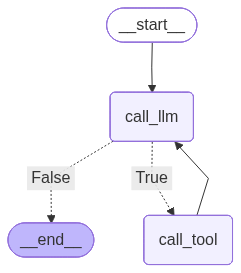

In [238]:
display(Image(agent.graph.get_graph().draw_mermaid_png()))

In [239]:
thread = {"configurable":{"thread_id": "thread_1"}}

In [240]:
msg = HumanMessage(content="What is the capital of Bangladesh?")

In [242]:
agent.graph.invoke({"messages":[msg]}, config= thread)

Invoking tool: tavily_search_results_json with args: {'query': 'capital of Bangladesh'}


{'messages': [HumanMessage(content='What is the capital of Bangladesh?', additional_kwargs={}, response_metadata={}, id='6f9aa773-7ec4-4a57-b6fa-9bc09f520601'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'mkdmvhb79', 'function': {'arguments': '{"query":"capital of Bangladesh"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 292, 'total_tokens': 312, 'completion_time': 0.035907975, 'prompt_time': 0.016084272, 'queue_time': 0.092875783, 'total_time': 0.051992247}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_f757f4b0bf', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--d0488894-51bb-45bb-97cf-7baee6e1bbca-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'capital of Bangladesh'}, 'id': 'mkdmvhb79', 'type': 'tool_call'}], usage_metadata={'input_tokens': 292, 'output_tokens': 20, 'total_tokens'

In [290]:
def call_agent(msg, thread, agent):
    if msg is None:
        for event in agent.graph.stream(None, config= thread):
            for v in event.values():
                print(v)
    else:
        for event in agent.graph.stream({"messages":[msg]}, config= thread):
            for v in event.values():
                print(v)

In [244]:
msg = HumanMessage(content="What about Germany'?")

In [ ]:
call_agent(msg, thread, agent)

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'bx4fnf814', 'function': {'arguments': '{"query":"capital of Germany"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 848, 'total_tokens': 868, 'completion_time': 0.015546497, 'prompt_time': 0.046886115, 'queue_time': 0.089738639, 'total_time': 0.062432612}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_4387d3edbb', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--9163ace8-0de7-4822-8d1f-8d1fbc4a5e50-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'capital of Germany'}, 'id': 'bx4fnf814', 'type': 'tool_call'}], usage_metadata={'input_tokens': 848, 'output_tokens': 20, 'total_tokens': 868})]}
Invoking tool: tavily_search_results_json with args: {'query': 'capital of Germany'}
{'messages': [ToolMessage(content='[{\'title\': \'Capital of

In [248]:
msg = HumanMessage(content="Who is the prime minister of Bangladesh in 2025?")

In [ ]:
call_agent(msg, thread, agent)

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'ehtfmmp4h', 'function': {'arguments': '{"query":"prime minister of Bangladesh 2025"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 2090, 'total_tokens': 2114, 'completion_time': 0.0224475, 'prompt_time': 0.091891402, 'queue_time': 0.086264593, 'total_time': 0.114338902, 'prompt_tokens_details': {'cached_tokens': 2048}}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_4387d3edbb', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--afe674b6-9368-4878-bd59-6e21aa8130f5-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'prime minister of Bangladesh 2025'}, 'id': 'ehtfmmp4h', 'type': 'tool_call'}], usage_metadata={'input_tokens': 2090, 'output_tokens': 24, 'total_tokens': 2114})]}
Invoking tool: tavily_search_results_json with args: {'query': 

In [250]:
msg = HumanMessage(content="What is the cureent population of Bangladesh?")

In [ ]:
call_agent(msg, thread, agent)

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '7h3q7x4cc', 'function': {'arguments': '{"query":"current population of Bangladesh"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 2520, 'total_tokens': 2541, 'completion_time': 0.016584416, 'prompt_time': 0.143426184, 'queue_time': 0.090540877, 'total_time': 0.1600106}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_4387d3edbb', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--61ed1f0e-4959-4eeb-a90c-95bf09c02e7b-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current population of Bangladesh'}, 'id': '7h3q7x4cc', 'type': 'tool_call'}], usage_metadata={'input_tokens': 2520, 'output_tokens': 21, 'total_tokens': 2541})]}
Invoking tool: tavily_search_results_json with args: {'query': 'current population of Bangladesh'}
{'messages': [To

In [253]:
states =agent.graph.get_state(thread)

In [257]:
states.next

()

### Agent With Human in a Loop......

In [278]:
thread = {"configurable":{"thread_id": "thread_hil1"}}

In [279]:
agent_hil = Agent(llm, [ts_tool], memory, is_interrupt=True, system_prompt="You are a helpful AI assistant.")

In [293]:
msg = HumanMessage(content="What is the cureent population of Bangladesh?")

In [294]:
call_agent(msg, thread, agent_hil)

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '3rc86w1gz', 'function': {'arguments': '{"query":"Bangladesh current population"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 332, 'total_tokens': 353, 'completion_time': 0.023378199, 'prompt_time': 0.018261909, 'queue_time': 0.089944003, 'total_time': 0.041640108}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_4387d3edbb', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--cc2233c3-09a5-4693-b37d-0410e44cb6e5-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Bangladesh current population'}, 'id': '3rc86w1gz', 'type': 'tool_call'}], usage_metadata={'input_tokens': 332, 'output_tokens': 21, 'total_tokens': 353})]}
()


In [295]:
states =agent_hil.graph.get_state(thread)

In [283]:
states.next

('call_tool',)

It stopped before tool calling..

In [296]:
call_agent(None, thread, agent_hil)

Invoking tool: tavily_search_results_json with args: {'query': 'Bangladesh current population'}
{'messages': [ToolMessage(content="[{'title': 'Bangladesh Population (2025) - Worldometer', 'url': 'https://www.worldometers.info/world-population/bangladesh-population/', 'content': 'Bangladesh 2025 population is estimated at 175,686,899 people at mid-year. Bangladesh population is equivalent to 2.13% of the total world population.', 'score': 0.99895966}, {'title': 'Bangladesh Population 2025 - World Population Review', 'url': 'https://worldpopulationreview.com/countries/bangladesh', 'content': 'Bangladesh gained its independence from Pakistan in 1971 and a nationwide census at the time confirmed that there were 71 million people living here. In 1980, the Bangladesh population had grown to 90.4 million and similar rises have been recorded on a decade by decade basis ever since. [...] The nationwide census in the country took place in March of 2011 and preliminary results claimed that the po

We can continue after approval by just passing None instead of msg, it starts from the last state again(Tool call)

### Looping (Human approval)

In [301]:
msg = HumanMessage(content="What is the cureent population of Berlin?")

In [302]:
call_agent(msg, thread, agent_hil)

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'zg42eaytc', 'function': {'arguments': '{"query":"Berlin current population 2025"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 1014, 'total_tokens': 1037, 'completion_time': 0.024780544, 'prompt_time': 0.060331403, 'queue_time': 0.088486498, 'total_time': 0.085111947}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_e750f72ec9', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--d325223c-27f7-4b34-ad3b-1bd702aa4177-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Berlin current population 2025'}, 'id': 'zg42eaytc', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1014, 'output_tokens': 23, 'total_tokens': 1037})]}
()


In [304]:
while agent_hil.graph.get_state(thread).next:
    print("\n", agent_hil.graph.get_state(thread),"\n")
    print("Last states:",agent_hil.graph.get_state(thread).values['messages'][-1])
    _input = input("continue?")
    if _input.lower() in ['y','yes','continue','c']:
        call_agent(None, thread, agent_hil)
    else:
        print("Stopping the agent.")
        break


 StateSnapshot(values={'messages': [HumanMessage(content='What is the cureent population of Bangladesh?', additional_kwargs={}, response_metadata={}, id='6aaf9d05-1313-4753-bc29-6105008eaf1f'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'vmqdzmrp6', 'function': {'arguments': '{"query":"population of Bangladesh"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 294, 'total_tokens': 314, 'completion_time': 0.033410816, 'prompt_time': 0.018725174, 'queue_time': 0.089288949, 'total_time': 0.05213599}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_e750f72ec9', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--2a471ce3-41e4-48bb-b71a-ef722b730280-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'population of Bangladesh'}, 'id': 'vmqdzmrp6', 'type': 'tool_call'}], usage_metadata={'input_tokens': 294